## 70. 単語ベクトルの和による特徴量
学習、検証、評価データについて特徴量行列とラベル行列を作成し保存せよ
問題50で作成したデータを使用する

In [3]:
import pandas as pd

DATA_PATH = "./data/news_aggregator_dataset/"

train_df = pd.read_csv(DATA_PATH + "train.txt", delimiter="\t")
valid_df = pd.read_csv(DATA_PATH + "valid.txt", delimiter="\t")
test_df = pd.read_csv(DATA_PATH + "test.txt", delimiter="\t")

print(train_df.head())

  CATEGORY                                              TITLE
0        b  Airline Mergers Pushed JetBlue's Pilots to Joi...
1        e      Andrew Garfield wants Black-HispanicSpiderman
2        b  Korean Bonds Fall as Choi Refrains From Signal...
3        m  REFILE-AstraZeneca fights to regain cancer mar...
4        e  Beyonce and Solange both take the plunge at fi...


In [4]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format("./data/GoogleNews-vectors-negative300.bin.gz", binary=True)
print(model["test"])

[-1.42578125e-01 -3.68652344e-02  1.35742188e-01 -6.20117188e-02
  7.95898438e-02  1.90429688e-02 -8.15429688e-02 -1.27929688e-01
 -2.95410156e-02  2.36328125e-01 -1.21582031e-01 -2.14843750e-01
  1.29882812e-01 -2.70996094e-02 -5.20019531e-02  2.15820312e-01
 -1.81640625e-01  5.10253906e-02 -1.60156250e-01 -1.76757812e-01
  1.83105469e-02 -4.12597656e-02 -2.32421875e-01 -1.03149414e-02
  1.45507812e-01  5.24902344e-02 -3.96484375e-01 -1.92871094e-02
  2.51770020e-03 -1.26953125e-02 -4.39453125e-02  3.07617188e-02
  9.57031250e-02 -1.75781250e-01  1.04370117e-02  1.89453125e-01
 -2.36328125e-01  4.37011719e-02  2.81250000e-01 -2.07519531e-02
 -1.81640625e-01 -2.17773438e-01  2.33398438e-01  5.29785156e-02
 -1.13769531e-01  9.39941406e-03 -1.49414062e-01  1.99218750e-01
 -1.75781250e-01  3.16406250e-01  8.10546875e-02 -6.12792969e-02
 -1.52343750e-01 -1.81884766e-02  8.25195312e-02  8.74023438e-02
 -1.18652344e-01 -2.59765625e-01 -1.68457031e-02  1.87988281e-02
  1.36108398e-02 -2.39257

In [6]:
import string
import torch

def t_word2vec(text:str):
    table = str.maketrans(string.punctuation, " "*len(string.punctuation))
    words = text.translate(table).split()
    vec = [model[word] for word in words if word in model]

    return torch.tensor(sum(vec) / len(vec))

In [10]:
x_train = torch.stack([t_word2vec(text) for text in train_df["TITLE"]])
x_valid = torch.stack([t_word2vec(text) for text in valid_df["TITLE"]])
x_test = torch.stack([t_word2vec(text) for text in test_df["TITLE"]])

print(x_train.size())
print(x_valid.size())
print(x_test.size())
print(x_train)

torch.Size([10684, 300])
torch.Size([1336, 300])
torch.Size([1336, 300])
tensor([[-0.0320,  0.0469, -0.1285,  ...,  0.0598,  0.0706,  0.0334],
        [ 0.1342,  0.0461, -0.0732,  ...,  0.0004,  0.0495, -0.0385],
        [ 0.0102,  0.1922, -0.0510,  ...,  0.0321,  0.0804,  0.0190],
        ...,
        [ 0.0596, -0.0215, -0.0660,  ..., -0.0506,  0.0126, -0.0528],
        [ 0.0660,  0.1197,  0.0617,  ..., -0.0637,  0.0367,  0.0248],
        [ 0.0409, -0.0189,  0.0151,  ..., -0.0743,  0.0713, -0.1081]])


In [11]:
category_dict = {"b":0, "t":1, "e":2, "m":3}
y_train = torch.tensor(train_df["CATEGORY"].map(lambda x: category_dict[x]).values)
y_valid = torch.tensor(valid_df["CATEGORY"].map(lambda x: category_dict[x]).values)
y_test = torch.tensor(test_df["CATEGORY"].map(lambda x: category_dict[x]).values)

print(y_train.size())
print(y_valid.size())
print(y_test.size())
print(y_train)

torch.Size([10684])
torch.Size([1336])
torch.Size([1336])
tensor([0, 2, 0,  ..., 2, 2, 2])


In [12]:
torch.save(x_train, DATA_PATH + "x_train.pt")
torch.save(x_valid, DATA_PATH + "x_valid.pt")
torch.save(x_test, DATA_PATH + "x_test.pt")
torch.save(y_train, DATA_PATH + "y_train.pt")
torch.save(y_valid, DATA_PATH + "y_valid.pt")
torch.save(y_test, DATA_PATH + "y_test.pt")

## 71. 単層ニューラルネットワークによる予測

In [13]:
from torch import nn

class SLPNet(nn.Module):
    def __init__(self, input_size, output_size) -> None:
        super().__init__()
        self.fc = nn.Linear(input_size, output_size, bias=False)
        nn.init.normal_(self.fc.weight, 0.0, 1.0) # 正規乱数で重みを初期化
    
    def forward(self, x):
        x = self.fc(x)
        return x

In [14]:
model = SLPNet(300, 4)
y_hat_1 = torch.softmax(model(x_train[:1]), dim=1)
Y_hat = torch.softmax(model(x_train[:4]), dim=1)

print(y_hat_1)
print(Y_hat)

tensor([[0.0719, 0.3223, 0.4005, 0.2053]], grad_fn=<SoftmaxBackward0>)
tensor([[0.0719, 0.3223, 0.4005, 0.2053],
        [0.0270, 0.0191, 0.5920, 0.3620],
        [0.2719, 0.2354, 0.0983, 0.3944],
        [0.4938, 0.2212, 0.2225, 0.0624]], grad_fn=<SoftmaxBackward0>)


## 72. 損失と勾配の計算
クロスエントロピー損失と行列Wに対する勾配を求める

In [15]:
criterion = nn.CrossEntropyLoss()

l_1 = criterion(model(x_train[:1]), y_train[:1])
model.zero_grad()
l_1.backward()

print(f"損失：{l_1: .4f}")
print(f"勾配：\n{model.fc.weight.grad}")

損失： 2.6325
勾配：
tensor([[ 0.0297, -0.0435,  0.1193,  ..., -0.0555, -0.0655, -0.0310],
        [-0.0103,  0.0151, -0.0414,  ...,  0.0193,  0.0227,  0.0108],
        [-0.0128,  0.0188, -0.0515,  ...,  0.0239,  0.0283,  0.0134],
        [-0.0066,  0.0096, -0.0264,  ...,  0.0123,  0.0145,  0.0069]])


In [16]:
l_4 = criterion(model(x_train[:4]), y_train[:4])
model.zero_grad()
l_4.backward()

print(f"損失：{l_4: .4f}")
print(f"勾配：\n{model.fc.weight.grad}")

損失： 1.8082
勾配：
tensor([[ 0.0044, -0.0278,  0.0288,  ..., -0.0029, -0.0278, -0.0159],
        [-0.0022,  0.0233, -0.0181,  ...,  0.0142,  0.0119,  0.0016],
        [-0.0175,  0.0127, -0.0111,  ...,  0.0143,  0.0053,  0.0057],
        [ 0.0153, -0.0082,  0.0003,  ..., -0.0256,  0.0106,  0.0085]])


## 73. 確率的勾配降下法による学習

In [17]:
from torch.utils.data import Dataset

class NewsDataset(Dataset):
    def __init__(self, X, y) -> None:
        super().__init__()
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [26]:
from torch.utils.data import DataLoader

dataset_train = NewsDataset(x_train, y_train)
dataset_valid = NewsDataset(x_valid, y_valid)
dataset_test = NewsDataset(x_test, y_test)

train_loader = DataLoader(dataset_train, batch_size=1, shuffle=True)
valid_loader = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

In [27]:
model = SLPNet(300, 4)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    loss_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_train += loss.item()
    
    loss_train /= len(train_loader)

    model.eval()
    with torch.no_grad():
        inputs, labels = next(iter(valid_loader))
        outputs = model(inputs)
        loss_valid = criterion(outputs, labels)
    
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}')  

epoch: 1, loss_train: 0.4862, loss_valid: 0.3715
epoch: 2, loss_train: 0.3136, loss_valid: 0.3257
epoch: 3, loss_train: 0.2814, loss_valid: 0.3219
epoch: 4, loss_train: 0.2645, loss_valid: 0.3124
epoch: 5, loss_train: 0.2536, loss_valid: 0.3065
epoch: 6, loss_train: 0.2462, loss_valid: 0.3066
epoch: 7, loss_train: 0.2401, loss_valid: 0.3041
epoch: 8, loss_train: 0.2356, loss_valid: 0.3043
epoch: 9, loss_train: 0.2329, loss_valid: 0.3050
epoch: 10, loss_train: 0.2293, loss_valid: 0.3046
epoch: 11, loss_train: 0.2266, loss_valid: 0.3061
epoch: 12, loss_train: 0.2245, loss_valid: 0.3074
epoch: 13, loss_train: 0.2227, loss_valid: 0.3072
epoch: 14, loss_train: 0.2204, loss_valid: 0.3079
epoch: 15, loss_train: 0.2193, loss_valid: 0.3127
epoch: 16, loss_train: 0.2185, loss_valid: 0.3098
epoch: 17, loss_train: 0.2167, loss_valid: 0.3099
epoch: 18, loss_train: 0.2158, loss_valid: 0.3146
epoch: 19, loss_train: 0.2153, loss_valid: 0.3162
epoch: 20, loss_train: 0.2144, loss_valid: 0.3192
epoch: 21

## 74. 正解率の計測

In [29]:
def calculate_accuracy(model, loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()
    return correct / total

accuracy_train = calculate_accuracy(model, train_loader)
accuracy_test = calculate_accuracy(model, test_loader)
print(f'正解率（学習データ）：{accuracy_train:.3f}')
print(f'正解率（評価データ）：{accuracy_test:.3f}')


正解率（学習データ）：0.930
正解率（評価データ）：0.897


## 75. 損失と正解率のプロット

In [30]:
def calculate_loss_and_accuracy(model, criterion, loader):
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()
    return loss / len(loader), correct / total

In [31]:
model = SLPNet(300, 4)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

log_train = []
log_valid = []

num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    loss_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    loss_train, accuracy_train = calculate_loss_and_accuracy(model, criterion, train_loader)
    loss_valid, accuracy_valid = calculate_loss_and_accuracy(model, criterion, valid_loader)

    log_train.append([loss_train, accuracy_train])
    log_valid.append([loss_valid, accuracy_valid])
    
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {accuracy_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {accuracy_valid:.4f}')  

epoch: 1, loss_train: 0.3263, accuracy_train: 0.8867, loss_valid: 0.3696, accuracy_valid: 0.8772
epoch: 2, loss_train: 0.2847, accuracy_train: 0.9026, loss_valid: 0.3377, accuracy_valid: 0.8915
epoch: 3, loss_train: 0.2643, accuracy_train: 0.9096, loss_valid: 0.3278, accuracy_valid: 0.8922
epoch: 4, loss_train: 0.2535, accuracy_train: 0.9130, loss_valid: 0.3208, accuracy_valid: 0.8945
epoch: 5, loss_train: 0.2423, accuracy_train: 0.9186, loss_valid: 0.3150, accuracy_valid: 0.8945
epoch: 6, loss_train: 0.2385, accuracy_train: 0.9191, loss_valid: 0.3155, accuracy_valid: 0.8990
epoch: 7, loss_train: 0.2311, accuracy_train: 0.9211, loss_valid: 0.3129, accuracy_valid: 0.8967
epoch: 8, loss_train: 0.2297, accuracy_train: 0.9229, loss_valid: 0.3165, accuracy_valid: 0.8975
epoch: 9, loss_train: 0.2248, accuracy_train: 0.9231, loss_valid: 0.3150, accuracy_valid: 0.8960
epoch: 10, loss_train: 0.2202, accuracy_train: 0.9251, loss_valid: 0.3114, accuracy_valid: 0.8982
epoch: 11, loss_train: 0.2216

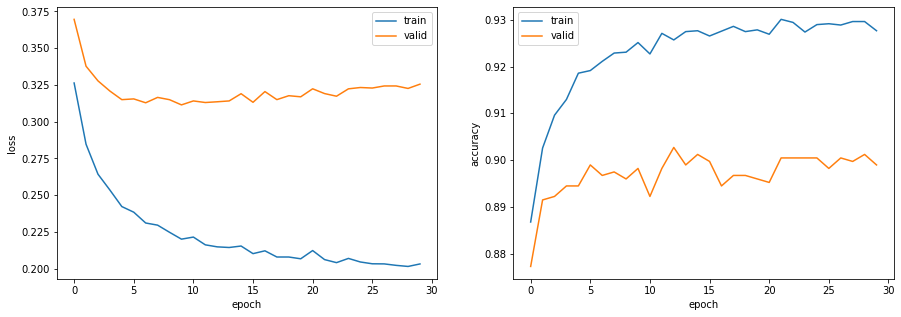

In [33]:
from matplotlib import pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_valid).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()